In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('blindern.csv', sep=';')

In [3]:
df

,Navn,Stasjon,Dato,Nedbør,Middeltemperatur,Maksimumstemperatur,Minimumstemperatur,Snødybde
0,Oslo - Blindern,SN18700,28.06.2018,0,"21,5","30,1","13,9",0
1,Oslo - Blindern,SN18700,29.06.2018,0,"17,6",24,"12,1",0
2,Oslo - Blindern,SN18700,30.06.2018,0,"17,3","24,6","10,3",0
3,Oslo - Blindern,SN18700,01.07.2018,0,"20,4","27,6","10,6",0
4,Oslo - Blindern,SN18700,02.07.2018,0,"21,7","28,9","13,1",0
...,...,...,...,...,...,...,...,...
2188,Oslo - Blindern,SN18700,24.06.2024,0,"18,7","24,9","10,4",0
2189,Oslo - Blindern,SN18700,25.06.2024,0,"18,1",23,"13,9",0
2190,Oslo - Blindern,SN18700,26.06.2024,0,19,"24,5","15,5",0
2191,Oslo - Blindern,SN18700,27.06.2024,0,"22,6","28,3",14,0


In [4]:
print(df.shape)

(2193, 8)


In [5]:
df['Dato'] = pd.to_datetime(df['Dato'], format='%d.%m.%Y')
df['Middeltemperatur'] = df['Middeltemperatur'].str.replace(',', '.').astype(float)
df

,Navn,Stasjon,Dato,Nedbør,Middeltemperatur,Maksimumstemperatur,Minimumstemperatur,Snødybde
0,Oslo - Blindern,SN18700,2018-06-28,0,21.5,"30,1","13,9",0
1,Oslo - Blindern,SN18700,2018-06-29,0,17.6,24,"12,1",0
2,Oslo - Blindern,SN18700,2018-06-30,0,17.3,"24,6","10,3",0
3,Oslo - Blindern,SN18700,2018-07-01,0,20.4,"27,6","10,6",0
4,Oslo - Blindern,SN18700,2018-07-02,0,21.7,"28,9","13,1",0
...,...,...,...,...,...,...,...,...
2188,Oslo - Blindern,SN18700,2024-06-24,0,18.7,"24,9","10,4",0
2189,Oslo - Blindern,SN18700,2024-06-25,0,18.1,23,"13,9",0
2190,Oslo - Blindern,SN18700,2024-06-26,0,19.0,"24,5","15,5",0
2191,Oslo - Blindern,SN18700,2024-06-27,0,22.6,"28,3",14,0


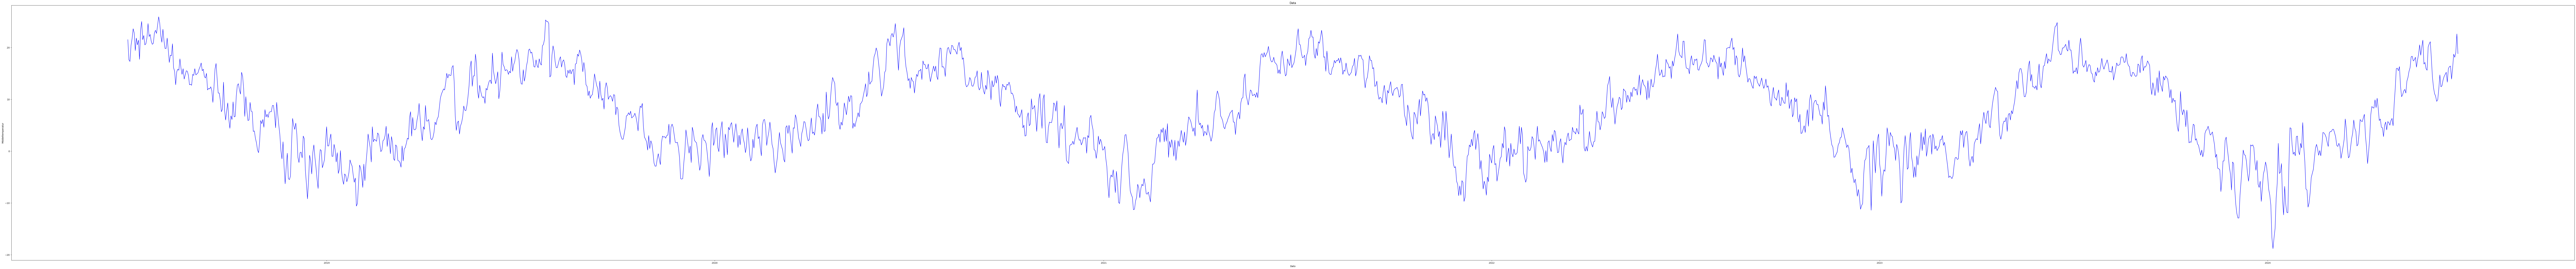

In [6]:
plt.figure(figsize=(200,20))
plt.plot(df['Dato'],df['Middeltemperatur'],color='blue',linestyle='-')

plt.xlabel('Dato')
plt.ylabel('Middeltemperatur')
plt.title("Data")

plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['Middeltemperatur'] = scaler.fit_transform(df[['Middeltemperatur']])

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.set_floatx('float64')

In [9]:
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [10]:
window_size = 24
dataset = df['Middeltemperatur'].values
dataset = dataset.reshape(-1,1)
X, y = create_dataset(dataset, window_size)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

split = int(len(X) * 0.7)
trainX, remainX = X[:split], X[split:]
trainY, remainY = y[:split], y[split:]

split2 = int(len(remainX) * 0.5)
testX, valX = remainX[:split2], remainX[split2:]
testY, valY = remainY[:split2], remainY[split2:]

In [11]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 24, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(trainX, trainY, epochs=30, batch_size=32, validation_data=(valX, valY), callbacks=[early_stopping])

Epoch 1/30
48/48 [==============================] - 4s 36ms/step - loss: 0.1835 - val_loss: 0.1428
Epoch 2/30
48/48 [==============================] - 1s 24ms/step - loss: 0.1053 - val_loss: 0.1034
Epoch 3/30
48/48 [==============================] - 1s 24ms/step - loss: 0.0962 - val_loss: 0.0946
Epoch 4/30
48/48 [==============================] - 1s 25ms/step - loss: 0.0846 - val_loss: 0.0939
Epoch 5/30
48/48 [==============================] - 1s 23ms/step - loss: 0.0830 - val_loss: 0.0898
Epoch 6/30
48/48 [==============================] - 1s 25ms/step - loss: 0.0833 - val_loss: 0.0993
Epoch 7/30
48/48 [==============================] - 1s 27ms/step - loss: 0.0832 - val_loss: 0.0940
Epoch 8/30
48/48 [==============================] - 1s 26ms/step - loss: 0.0784 - val_loss: 0.0977
Epoch 9/30
48/48 [==============================] - 1s 27ms/step - loss: 0.0812 - val_loss: 0.0880
Epoch 10/30
48/48 [==============================] - 1s 24ms/step - loss: 0.0802 - val_loss: 0.0799
Epoch 11/

In [13]:
predictions = model.predict(testX)
predictions = predictions.reshape(testY.shape)
mape = np.mean(np.abs((testY - predictions) / testY)) * 100
r2 = r2_score(testY, predictions)
mae = mean_absolute_error(testY, predictions)
rmse = np.sqrt(mean_squared_error(testY, predictions))
mmae = np.mean(np.abs((testY - predictions) / testY))

print("MAPE:", mape)
print("R2 Score:", r2)
print("MAE:", mae)
print("RMSE:", rmse)
print("mMAE:", mmae)

MAPE: 63.73252518724992
R2 Score: 0.9267331979546316
MAE: 0.209212643920215
RMSE: 0.2657046117966535
mMAE: 0.6373252518724992


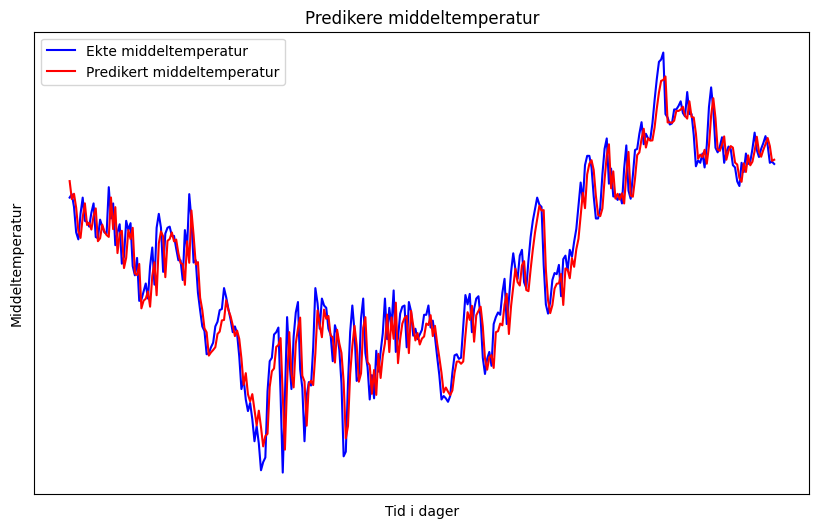

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Ekte middeltemperatur', color='blue')
plt.plot(predictions, label='Predikert middeltemperatur', color='red')
plt.title('Predikere middeltemperatur')
plt.xlabel('Tid i dager')
plt.ylabel('Middeltemperatur')
plt.yscale('linear')
plt.xticks([], [])
plt.yticks([], [])
plt.legend()

plt.show()